<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [137]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=False, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=False, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [138]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше батч-сайз, тем меньше итераций в каждой эпохе. С этой точки зрения, скорость обучения как будто должна расти, но я думаю дольше будет сходиться loss.

Посмотрим на какую-нибудь картинку:

In [97]:
trainset[0][0].shape

torch.Size([1, 28, 28])

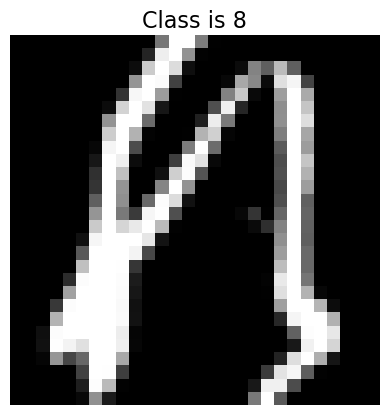

In [98]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16)

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





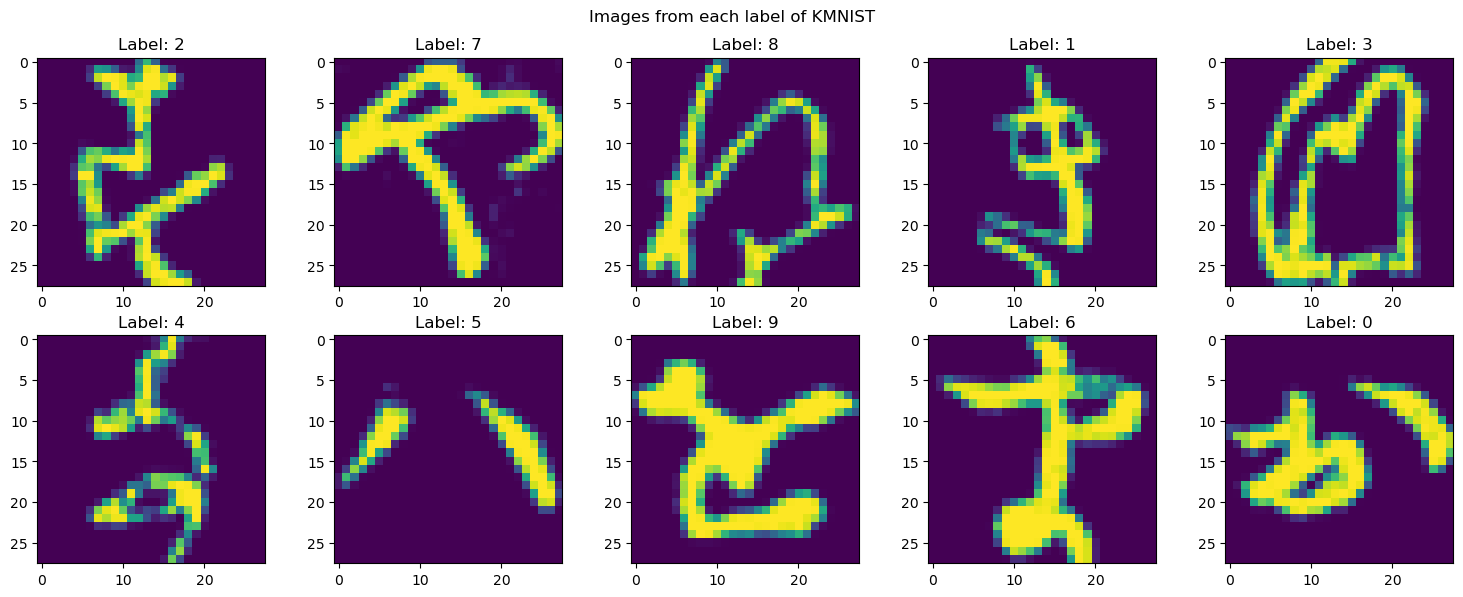

In [99]:
images_per_label = {}
trainloader_to_plot = DataLoader(trainset, batch_size=1, shuffle=True)
# Collect one image from each label
for image, label in trainloader_to_plot:
    label = label.item()
    if label not in images_per_label:
        images_per_label[label] = image.squeeze(0)

    if len(images_per_label) == 10:
        break

# Plot the collected images
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Images from each label of KMNIST")

for i, (label, image) in enumerate(images_per_label.items()):
    ax = axs[i // 5, i % 5]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(f"Label: {label}")

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [133]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()  #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(
        self, x
    ):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** 784 + 256 + 2128 + 10 = 3178

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [101]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad():  # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [102]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [103]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
## YOUR CODE HERE


Epoch=1 loss=0.9123
Epoch=2 loss=0.4353
Epoch=3 loss=0.3505
Epoch=4 loss=0.2969
Epoch=5 loss=0.2551
Epoch=6 loss=0.2219
Epoch=7 loss=0.1939
Epoch=8 loss=0.1704
Epoch=9 loss=0.1505
Epoch=10 loss=0.1332
CPU times: user 1min 3s, sys: 1.31 s, total: 1min 5s
Wall time: 1min 8s


In [104]:
print(f"Значение accuracy для тестовой выборки: {get_accuracy(fc_net, testloader)}")

Значение accuracy для тестовой выборки: 0.869


### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [139]:
m = trainset.train_data.float().mean() / 255.0
sigma = trainset.train_data.float().std() / 255.0
print(f"Mean:{m.item()}, Sigma:{sigma.item()}")

transform_with_norm = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(m, sigma)]
)

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

Mean:0.19176211953163147, Sigma:0.3483428359031677


In [140]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [141]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [142]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
## YOUR CODE HERE



Epoch=1 loss=0.6885
Epoch=2 loss=0.3012
Epoch=3 loss=0.2216
Epoch=4 loss=0.1732
Epoch=5 loss=0.1393
Epoch=6 loss=0.1127
Epoch=7 loss=0.0922
Epoch=8 loss=0.0754
Epoch=9 loss=0.0616
Epoch=10 loss=0.0501
CPU times: user 1min, sys: 1.31 s, total: 1min 1s
Wall time: 1min 24s


In [143]:
print(
    f"Значение accuracy для тестовой выборки после нормализации: {get_accuracy(fc_net, testloader)}"
)

Значение accuracy для тестовой выборки после нормализации: 0.8997


Как изменилась `accuracy` после нормализации?

Оно прилично повысилось!

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

Давайте немного модифицируем наш класс, чтобы было удобно проверять различные функции активации

In [115]:
## YOUR CODE HERE
class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__()  #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = activation

    def forward(
        self, x
    ):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

In [117]:
%%time
n_epochs = 10
accuracy_scores = []
loss_function = nn.CrossEntropyLoss()
for activation_func in [F.gelu, F.tanh, F.sigmoid]:
    loss_history = []
    print(f'Activation function: {activation_func.__name__}')
    fc_net = FCNet(activation=activation_func)
    optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    accuracy_scores.append(get_accuracy(fc_net, testloader))
## YOUR CODE HERE


Activation function: gelu
Epoch=1 loss=0.6582
Epoch=2 loss=0.2809
Epoch=3 loss=0.2034
Epoch=4 loss=0.1554
Epoch=5 loss=0.1226
Epoch=6 loss=0.0977
Epoch=7 loss=0.0793
Epoch=8 loss=0.0639
Epoch=9 loss=0.0505
Epoch=10 loss=0.0409
Activation function: tanh
Epoch=1 loss=0.7670
Epoch=2 loss=0.3864
Epoch=3 loss=0.2617
Epoch=4 loss=0.1880
Epoch=5 loss=0.1394
Epoch=6 loss=0.1046
Epoch=7 loss=0.0799
Epoch=8 loss=0.0594
Epoch=9 loss=0.0445
Epoch=10 loss=0.0329
Activation function: sigmoid
Epoch=1 loss=1.5777
Epoch=2 loss=0.7688
Epoch=3 loss=0.5499
Epoch=4 loss=0.4466
Epoch=5 loss=0.3770
Epoch=6 loss=0.3238
Epoch=7 loss=0.2811
Epoch=8 loss=0.2461
Epoch=9 loss=0.2159
Epoch=10 loss=0.1906
CPU times: user 3min 22s, sys: 4.2 s, total: 3min 26s
Wall time: 4min 29s


Быстрее всего посчиталась сигмоида, дальше tanh и последним - gelu

In [118]:
for i, activation_func in enumerate([F.gelu, F.tanh, F.sigmoid]):
    print(f"{activation_func.__name__} accuracy: {accuracy_scores[i]}")

gelu accuracy: 0.9048
tanh accuracy: 0.8982
sigmoid accuracy: 0.8556


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Однозначно, GeLU

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [120]:
## YOUR CODE HERE
class FCNet(nn.Module):
    def __init__(self):
        super().__init__()  #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(
        self, x
    ):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = F.gelu(x)
        x = self.fc3(x)
        return x

In [121]:
%%time
n_epochs = 10
accuracy_scores = []
loss_function = nn.CrossEntropyLoss()
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]
for optimizer_class in optimizers:
    print(f'Optimizer: {optimizer_class.__name__}')
    loss_history = []
    optimizer = optimizer_class(fc_net.parameters(), lr=3e-4)
    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: # Получаем батч тренировочных картинок
            optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
            outputs = fc_net(images) # делаем предсказания
            loss = loss_function(outputs, labels) # считаем лосс
            loss.backward() # считаем градиенты
            optimizer.step() # делаем шаг градиентного спуска
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))

        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
    accuracy_scores.append(get_accuracy(fc_net, testloader))

Optimizer: Adam
Epoch=1 loss=0.1682
Epoch=2 loss=0.1473
Epoch=3 loss=0.1304
Epoch=4 loss=0.1160
Epoch=5 loss=0.1030
Epoch=6 loss=0.0911
Epoch=7 loss=0.0805
Epoch=8 loss=0.0710
Epoch=9 loss=0.0626
Epoch=10 loss=0.0553
Optimizer: RMSprop
Epoch=1 loss=0.0529
Epoch=2 loss=0.0410
Epoch=3 loss=0.0355
Epoch=4 loss=0.0298
Epoch=5 loss=0.0258
Epoch=6 loss=0.0216
Epoch=7 loss=0.0181
Epoch=8 loss=0.0149
Epoch=9 loss=0.0122
Epoch=10 loss=0.0098
Optimizer: Adagrad
Epoch=1 loss=0.0069
Epoch=2 loss=0.0064
Epoch=3 loss=0.0063
Epoch=4 loss=0.0062
Epoch=5 loss=0.0061
Epoch=6 loss=0.0060
Epoch=7 loss=0.0059
Epoch=8 loss=0.0059
Epoch=9 loss=0.0058
Epoch=10 loss=0.0058
CPU times: user 3min 11s, sys: 4.12 s, total: 3min 15s
Wall time: 4min 22s


In [122]:
for i, optimizer_class in enumerate(optimizers):
    print(f'{optimizer_class.__name__} accuracy: {accuracy_scores[i]}')

Adam accuracy: 0.8856
RMSprop accuracy: 0.8867
Adagrad accuracy: 0.8938


С использованием какого оптимизатора удалось досчить наибольшей `accuracy`?

Однозначно, Adagrad!

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [123]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # если элемент x < 0, то 0, если >= 0, то x
        return torch.max(torch.tensor(0, dtype=x.dtype, device=x.device), x)

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [144]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self):
        super().__init__()  #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28 * 28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation = CustomReLU()

    def forward(
        self, x
    ):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы
        x = x.view(-1, 28 * 28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

In [145]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [146]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")
## YOUR CODE HERE



Epoch=1 loss=0.6875
Epoch=2 loss=0.3008
Epoch=3 loss=0.2228
Epoch=4 loss=0.1737
Epoch=5 loss=0.1385
Epoch=6 loss=0.1124
Epoch=7 loss=0.0917
Epoch=8 loss=0.0750
Epoch=9 loss=0.0621
Epoch=10 loss=0.0497
CPU times: user 1min 9s, sys: 1.28 s, total: 1min 10s
Wall time: 1min 27s


In [147]:
print(
    f"Значение accuracy для тестовой выборки после нормализации: {get_accuracy(fc_net, testloader)}"
)

Значение accuracy для тестовой выборки после нормализации: 0.8989


Значение немного изменилось, но вероятно, это потому что батчи в эпохах по разному собираются. Возможно, большее количество эпох решило бы эту проблему. В любом случае, полученное здесь и в задании 4 значения похожи)

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.


Этот бот очень странный!)))

![Этот бот странный)](../data/I_missed_ML_deadline.jpg)

![Этот бот странный)](../data/beautiful_nature.jpg)

![Этот бот странный)](../data/bioinformatic_and_biologist_arguing.jpg)